In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import sklearn
import random
import sys
import os
import matplotlib.pyplot as plt
import math
import scipy
from distcorr import distcorr
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [2]:
def normal(x, mu, sigma):
    return (2.*np.pi*sigma**2.)**-.5*np.exp(-.5*(x-mu)**2./sigma**2.)

2000


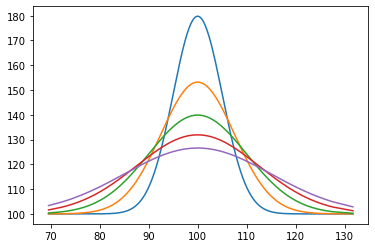

In [3]:
x = []

mu, sigma, n = 100, 10, 2000

np.random.seed(0)
x = np.random.normal(mu, sigma, n)
x.sort()

y = 100 + normal(x, mu, sigma*0.5)*1000
y2 = 100 + normal(x, mu, sigma*0.75)*1000
y3 = 100 + normal(x, mu, sigma*1)*1000
y4 = 100 + normal(x, mu, sigma*1.25)*1000
y5 = 100 + normal(x, mu, sigma*1.5)*1000

print(len(x))

dataset = np.vstack((x, y, y2, y3, y4, y5)).T
plt.plot(dataset[:, 0], dataset[:, 1:])



In [4]:
noise_value = 2

np.random.seed(0)
noise = np.random.normal(0, noise_value, x.shape)
noise2 = np.random.normal(0, noise_value, x.shape)
noise3 = np.random.normal(0, noise_value, x.shape)
noise4 = np.random.normal(0, noise_value, x.shape)
noise5 = np.random.normal(0, noise_value, x.shape)

y_noise = y + noise
y_noise2 = y2 + noise2
y_noise3 = y3 + noise3
y_noise4 = y4 + noise4
y_noise5 = y5 + noise5

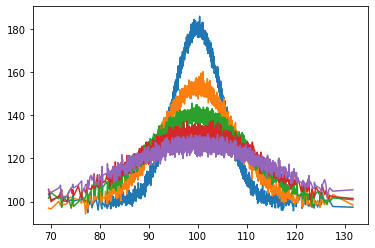

In [5]:
noised_dataset = np.vstack((x, y_noise, y_noise2, y_noise3, y_noise4, y_noise5)).T
plt.plot(noised_dataset[:, 0], noised_dataset[:, 1:])

In [6]:
average_value = np.mean(noised_dataset.flatten())
average_value

124.09768661014816

In [7]:
NAN = 0

def fill_nan(array, REPLACE_COUNT):
    array.flat[np.random.choice(array.size, int(REPLACE_COUNT), replace=False)] = NAN

    return array

In [8]:
full_data = noised_dataset.copy()
missing_data = fill_nan(noised_dataset.copy(), noised_dataset.copy().size*0.2)

In [9]:
bins = np.linspace(0, 10)
y_binned = np.digitize(full_data[:,0], bins)


In [10]:
x_train, x_test, y_train, y_test = train_test_split(missing_data, full_data, stratify=y_binned, random_state=0)

In [11]:
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
BATCH_SIZE = -1
NUM_FEATURES = 6
BATCH_SIZE_TEST = -1

In [12]:
x_train = torch.from_numpy(x_train)
#x_train = x_train.to(device)
x_train = x_train.view(BATCH_SIZE, NUM_FEATURES)

y_train = torch.from_numpy(y_train)
#y_train = y_train.to(device)
y_train = y_train.view(BATCH_SIZE, NUM_FEATURES)

x_test = torch.from_numpy(x_test)
#x_test = x_test.to(device)
x_test = x_test.view(BATCH_SIZE_TEST, NUM_FEATURES)

y_test = torch.from_numpy(y_test)
#y_test = y_test.to(device)
y_test = y_test.view(BATCH_SIZE_TEST, NUM_FEATURES)

x_train.shape

torch.Size([1500, 6])

In [13]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.enc1 = nn.Linear(in_features=6, out_features=8)
        self.enc2 = nn.Linear(in_features=8, out_features=16)

        self.dec2 = nn.Linear(in_features=16, out_features=8)
        self.dec3 = nn.Linear(in_features=8, out_features=6)

    def forward(self, x):
        x = F.leaky_relu(self.enc1(x))
        x = F.leaky_relu(self.enc2(x))
        x = F.leaky_relu(self.dec2(x))
        x = self.dec3(x)
        return x

In [14]:
# CREATE A SEED FOR CONSISTENT WEIGHT INITIALIZATIONS - FOR TESTING PURPOSES
random.seed(2)
torch.manual_seed(random.randint(1, 10))
net = Autoencoder().double()
#net.to(device)

In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [16]:
def train(net):
    train_loss = []
    torch.set_printoptions(precision=2, sci_mode=False)
    np.set_printoptions(precision=2, suppress=True)

    for epoch in range(NUM_EPOCHS):
        # running_loss: LOSS OF THE PREDICTED MISSING VALUE ONLY
        # overall_loss: LOSS OF ALL RECONSTRUCTED VALUES

        running_loss = 0.0
        overall_loss = 0.0
        count = 0
        for missing_data, full_data in zip(x_train, y_train):
            optimizer.zero_grad()
            outputs = net(missing_data.double())

            # LEARN FROM LOSS OF ALL RECONSTRUCTED VALUES
            loss = criterion(outputs, full_data)
            loss.backward()
            optimizer.step()
            overall_loss += loss.item()
            
            # COMPUTE LOSS OF PREDICTED MISSING VALUE
            if NAN in missing_data:
                for index in range(len(missing_data)):
                    if missing_data[index] == NAN:
                        predicted_loss = criterion(outputs[index], full_data[index])
                        running_loss += predicted_loss.item()
                        count += 1
            
            # PRINT ALL VALUES ON LAST EPOCH FOR TESTING PURPOSES
            if epoch == NUM_EPOCHS-1:
                if missing_data.detach().numpy().all() == full_data.detach().numpy().all():
                    print("Input: ", missing_data)
                    print("Target: ", full_data)
                    print("Outputs: ", outputs)
                else:
                    print("Input (missing): ", missing_data)
                    print("Target (missing): ", full_data)
                    print("Outputs (missing): ", outputs)
        
      #  loss = running_loss / count
        overall_loss = overall_loss / len(x_train)
        x_loss = running_loss / count
        train_loss.append(loss)



        print('Epoch {} of {}, Train Loss: {:.5f}, Overall: {:.5f}'
             .format(epoch+1, NUM_EPOCHS, x_loss, overall_loss))

    return train_loss


def test(net):

    net.eval()
    count = 0

    with torch.no_grad():
        test_loss = []
        running_loss = 0.0
        overall_loss = 0.0

        for missing_data, full_data in zip(x_test, y_test):
            outputs = net(missing_data.double())

            # LEARN FROM LOSS OF ALL RECONSTRUCTED VALUES
            loss = criterion(outputs, full_data)
            overall_loss += loss.item()

            if NAN in missing_data:
                for index in range(len(missing_data)):
                    if missing_data[index] == NAN:
                        predicted_loss = criterion(outputs[index], full_data[index])
                        running_loss += predicted_loss.item()
                        count += 1
            
            if missing_data.detach().numpy().all() == full_data.detach().numpy().all():
                print("Input: ", missing_data)
                print("Target: ", full_data)
                print("Outputs: ", outputs)
            else:
                print("Input (missing): ", missing_data)
                print("Target (missing): ", full_data)
                print("Outputs (missing): ", outputs)

        overall_loss = overall_loss / len(x_test)
        x_loss = running_loss / count
        test_loss.append(overall_loss)
        print('Test Loss: {:.3f}, Overall: {:.5f}'.format(x_loss, overall_loss))

        return test_loss

In [118]:
results = train(net)

e=torch.float64,
       grad_fn=<AddBackward0>)
Input (missing):  tensor([110.82,   0.00, 116.34, 119.06, 122.29, 120.05], dtype=torch.float64)
Target (missing):  tensor([110.82, 108.89, 116.34, 119.06, 122.29, 120.05], dtype=torch.float64)
Outputs (missing):  tensor([108.23, 112.63, 117.93, 119.55, 119.16, 118.04], dtype=torch.float64,
       grad_fn=<AddBackward0>)
Input (missing):  tensor([  0.00, 112.19, 119.90, 125.64,   0.00, 121.76], dtype=torch.float64)
Target (missing):  tensor([109.77, 112.19, 119.90, 125.64, 125.00, 121.76], dtype=torch.float64)
Outputs (missing):  tensor([ 98.33, 110.38, 118.53, 121.10, 121.80, 119.26], dtype=torch.float64,
       grad_fn=<AddBackward0>)
Input (missing):  tensor([ 94.51,   0.00, 136.76, 135.32, 125.75, 124.72], dtype=torch.float64)
Target (missing):  tensor([ 94.51, 142.30, 136.76, 135.32, 125.75, 124.72], dtype=torch.float64)
Outputs (missing):  tensor([ 94.83, 145.27, 136.87, 130.19, 125.22, 120.24], dtype=torch.float64,
       grad_fn=<A

In [119]:
test_result = test(net)

119.52], dtype=torch.float64)
Target (missing):  tensor([ 92.59, 122.04, 130.27, 132.13, 126.06, 119.52], dtype=torch.float64)
Outputs (missing):  tensor([ 91.91, 127.76, 126.37, 122.90, 121.31, 117.35], dtype=torch.float64)
Input (missing):  tensor([  0.00, 181.88, 152.40, 142.44, 131.80, 126.67], dtype=torch.float64)
Target (missing):  tensor([ 99.33, 181.88, 152.40, 142.44, 131.80, 126.67], dtype=torch.float64)
Outputs (missing):  tensor([104.15, 179.04, 155.60, 141.79, 134.58, 128.16], dtype=torch.float64)
Input (missing):  tensor([ 96.58, 163.78, 143.91, 137.08, 129.35,   0.00], dtype=torch.float64)
Target (missing):  tensor([ 96.58, 163.78, 143.91, 137.08, 129.35, 127.78], dtype=torch.float64)
Outputs (missing):  tensor([ 99.22, 163.22, 146.03, 135.59, 131.18, 124.62], dtype=torch.float64)
Input (missing):  tensor([ 83.45,   0.00, 107.22, 109.98, 113.31,   0.00], dtype=torch.float64)
Target (missing):  tensor([ 83.45,  99.97, 107.22, 109.98, 113.31, 116.22], dtype=torch.float64)


In [120]:
torch.save(net, './model4')

In [17]:
net = torch.load('model4')
net

Autoencoder(
  (enc1): Linear(in_features=6, out_features=8, bias=True)
  (enc2): Linear(in_features=8, out_features=16, bias=True)
  (dec2): Linear(in_features=16, out_features=8, bias=True)
  (dec3): Linear(in_features=8, out_features=6, bias=True)
)

In [18]:
predicted_set = net(x_test.double())
predicted_set = predicted_set.detach().numpy()

real_set = y_test.detach().numpy()

In [19]:
feature_1 = []
feature_2 = []
feature_3 = []
feature_4 = []
feature_5 = []


for missing_data, full_data, predicted in zip(x_test, real_set, predicted_set):
    if NAN in missing_data:
        for i in range(len(missing_data)):
            if missing_data[i] == NAN:
                if i == 1:
                    feature_1.append([full_data[0].item(), full_data[i].item(), predicted[i].item()])
                if i == 2:
                    feature_2.append([full_data[0].item(), full_data[i].item(), predicted[i].item()])
                if i == 3:
                    feature_3.append([full_data[0].item(), full_data[i].item(), predicted[i].item()])
                if i == 4:
                    feature_4.append([full_data[0].item(), full_data[i].item(), predicted[i].item()])
                if i == 5:
                    feature_5.append([full_data[0].item(), full_data[i].item(), predicted[i].item()])

In [20]:
feature_1 = np.asarray(feature_1)
feature_2 = np.asarray(feature_2)
feature_3 = np.asarray(feature_3)
feature_4 = np.asarray(feature_4)
feature_5 = np.asarray(feature_5)

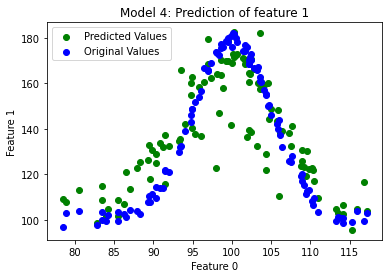

In [21]:
plt.scatter(feature_1[:, 0], feature_1[:, 2], color='green', label='Predicted Values')
plt.scatter(feature_1[:, 0], feature_1[:, 1], color='blue', label='Original Values')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()
plt.title('Model 4: Prediction of feature 1')
plt.savefig('model4Results.pdf')
plt.show()

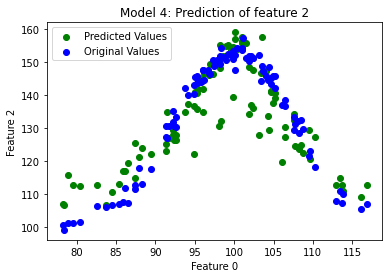

In [22]:
plt.scatter(feature_2[:, 0], feature_2[:, 2], color='green', label='Predicted Values')
plt.scatter(feature_2[:, 0], feature_2[:, 1], color='blue', label='Original Values')
plt.xlabel('Feature 0')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Model 4: Prediction of feature 2')
plt.savefig('model4Results2.pdf')
plt.show()

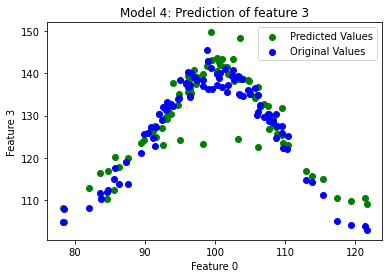

In [23]:
plt.scatter(feature_3[:, 0], feature_3[:, 2], color='green', label='Predicted Values')
plt.scatter(feature_3[:, 0], feature_3[:, 1], color='blue', label='Original Values')
plt.xlabel('Feature 0')
plt.ylabel('Feature 3')
plt.legend()
plt.title('Model 4: Prediction of feature 3')
plt.savefig('model4Results3.pdf')
plt.show()

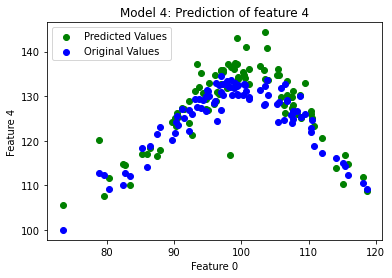

In [24]:
plt.scatter(feature_4[:, 0], feature_4[:, 2], color='green', label='Predicted Values')
plt.scatter(feature_4[:, 0], feature_4[:, 1], color='blue', label='Original Values')
plt.xlabel('Feature 0')
plt.ylabel('Feature 4')
plt.legend()
plt.title('Model 4: Prediction of feature 4')
plt.savefig('model4Results4.pdf')
plt.show()

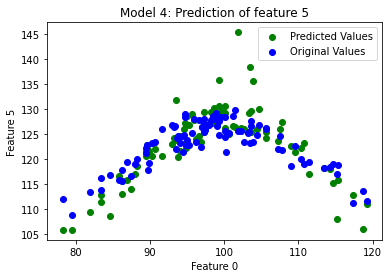

In [25]:
plt.scatter(feature_5[:, 0], feature_5[:, 2], color='green', label='Predicted Values')
plt.scatter(feature_5[:, 0], feature_5[:, 1], color='blue', label='Original Values')
plt.xlabel('Feature 0')
plt.ylabel('Feature 5')
plt.legend()
plt.title('Model 4: Prediction of feature 5')
plt.savefig('model4Results5.pdf')
plt.show()

In [130]:
from scipy import stats
from statsmodels.stats import weightstats as stets

p_values = []
t_values = []

for i in range(6):
    ttest, pval = stats.ttest_ind(real_set[:, i], predicted_set[:, i])
    print("P-value for significance: ", pval)
    print("TTEST: ", ttest)
    p_values.append(pval)
    t_values.append(ttest)

    if pval<0.05:
        print("Conclusion: Reject Null Hypothesis")
    else:
        print("Conclusion: Accept Null Hypothesis")

print("Mean P-Value: ", np.mean(p_values))
print("Mean T-Value: ", np.mean(t_values))

P-value for significance:  0.5389386073906421
TTEST:  -0.614630891332346
Conclusion: Accept Null Hypothesis
P-value for significance:  0.291576164024055
TTEST:  -1.055228613280695
Conclusion: Accept Null Hypothesis
P-value for significance:  0.4152089811755725
TTEST:  -0.8151009792033168
Conclusion: Accept Null Hypothesis
P-value for significance:  0.5706942616789386
TTEST:  -0.5672170821036023
Conclusion: Accept Null Hypothesis
P-value for significance:  0.015274081562431225
TTEST:  -2.4300047566018734
Conclusion: Reject Null Hypothesis
P-value for significance:  0.8020229155568843
TTEST:  -0.2507967013919466
Conclusion: Accept Null Hypothesis
Mean P-Value:  0.43895250189808727
Mean T-Value:  -0.9554965039856299


In [132]:
features = [feature_1, feature_2, feature_3, feature_4, feature_5]

for i in range(0, 5):
    print("Original Column: ", i+1, distcorr(features[i][:, 0], features[i][:, 1]))
    print("Predicted Column: ", i+1, distcorr(features[i][:, 0], features[i][:, 2]))

Original Column:  1 0.5561374996987656
Predicted Column:  1 0.492755736107808
Original Column:  2 0.628021540730346
Predicted Column:  2 0.5495509163689579
Original Column:  3 0.5555222607468784
Predicted Column:  3 0.5265745736553182
Original Column:  4 0.5331771301000858
Predicted Column:  4 0.5189852487153499
Original Column:  5 0.5331292890966799
Predicted Column:  5 0.5586330145630136
